In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import sys
import os

from wordcloud import WordCloud, STOPWORDS
from ast import literal_eval

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


pd.options.plotting.backend = "plotly"
# pio.renderers.default = 'browser'
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")


In [57]:
pt_df = pd.read_csv("./data/pt_ratings.csv")
salaries_df = pd.read_csv("./data/salaries.csv")
rmp_df = pd.read_csv("./data/rmp_ratings.csv")
reviews_df = pd.read_csv("./data/reviews.csv", index_col=0)


In [58]:
# Drop professors w/o any ratings / reviews
pt_df = pt_df.dropna(subset=["average_rating", "reviews"])
# pt_df = pt_df.drop(columns=["slug"])

# Join names to help name search in salaries
salaries_df["name"] = salaries_df["employee"].apply(
    lambda x: " ".join(x.split(", ")[::-1])
)
salaries_df["department"] = salaries_df["department"].str.replace("\n", " ").str.strip()
salaries_df["salary"] = (
    salaries_df["salary"].replace("[\$,]", "", regex=True).astype(float)
)
salaries_df["school"] = salaries_df["department"].str.split("-").str[0]
# TODO: Use division instead of department cause less unique values
salaries_df.loc[~salaries_df["department"].str.contains("-"), "school"] = np.nan


In [59]:
# TODO: needs to go
for name in pt_df[pt_df.duplicated(subset=["name"])]["name"].unique():
    rows = pt_df[pt_df["name"] == name]

    assert len(rows["type"].unique()) == 1
    assert len(rows["name"].unique()) == 1

    new_row = {
        "courses": np.concatenate(rows["courses"].apply(literal_eval).values).reshape(
            -1
        ),
        "reviews": np.concatenate(rows["reviews"].apply(literal_eval).values).reshape(
            -1
        ),
        "slug": rows.iloc[0]["slug"],
        "type": rows.iloc[0]["type"],
        "name": rows.iloc[0]["name"],
        "average_rating": np.average(
            rows["average_rating"],
            weights=rows["reviews"].apply(literal_eval).apply(len),
        ),
    }

    pt_df = pt_df.drop(rows.index)
    pt_df = pt_df.append(new_row, ignore_index=True)


/tmp/ipykernel_20248/3979907707.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [60]:
# TODO: needs to go
assert len(pt_df) == len(pt_df.drop_duplicates(subset=["name"]))

In [61]:
salaries_df = salaries_df.groupby(["name", "year"], as_index=False).agg(
    {
        "school": "first",
        "salary": "sum",
    }
)
salaries_df["num_reviews"] = 1
reviews_df["year"] = pd.DatetimeIndex(reviews_df["created"]).year

merged_df = salaries_df.merge(reviews_df, on=["name", "year"], how="right")
merged_df["num_reviews"] = 1


In [62]:
merged_df[merged_df.name.str.contains("Deshpande")]

,name,year,school,salary,num_reviews,course,review,rating,created
1144,Amol Deshpande,2012,NaN,NaN,1,CMSC424,Prof. Deshpande was a great professor (especia...,5,2012-06-22 00:33:00+00:00
1145,Amol Deshpande,2011,NaN,NaN,1,CMSC724,A very good course and very good Prof. The cou...,5,2011-08-05 18:16:00+00:00
1146,Amol Deshpande,2007,NaN,NaN,1,CMSC724,A very good course! Midterm and final will be ...,5,2007-12-02 14:22:00+00:00
1147,Amol Deshpande,2018,NaN,NaN,1,CMSC424,"Very nice professor, willing to work with his ...",5,2018-01-24 06:44:21+00:00
1148,Amol Deshpande,2020,CMNS,206091.58,1,CMSC424,Nice professor. Didn't do the best job handlin...,4,2020-05-02 17:18:09+00:00
1149,Amol Deshpande,2020,CMNS,206091.58,1,CMSC424,This class as an online course has been horrib...,1,2020-11-01 18:36:43+00:00
1150,Amol Deshpande,2020,CMNS,206091.58,1,CMSC424,CMSC424 during the full covid semester is actu...,1,2020-11-03 05:09:29+00:00
1151,Amol Deshpande,2020,CMNS,206091.58,1,NaN,Legit an extemely horrible class that has been...,1,2020-11-16 02:47:39+00:00
1152,Amol Deshpande,2020,CMNS,206091.58,1,CMSC424,"The lectures are worthless, the homeworks take...",1,2020-11-16 02:50:12+00:00
1153,Amol Deshpande,2020,CMNS,206091.58,1,CMSC424,First course I've ever had to withdraw from (3...,1,2020-12-14 07:27:33+00:00


In [63]:
merged_df[merged_df["name"] == "Justin Olav Wyss-Gallifent"]


,name,year,school,salary,num_reviews,course,review,rating,created
13210,Justin Olav Wyss-Gallifent,2016,CMNS,85228.14,1,MATH246,"Best Math professor I've ever had at UMD, hand...",5,2016-08-25 17:52:00+00:00
13211,Justin Olav Wyss-Gallifent,2015,CMNS,85228.14,1,MATH241,"He is a great teacher I highly recommend him, ...",5,2015-06-03 11:41:00+00:00
13212,Justin Olav Wyss-Gallifent,2015,CMNS,85228.14,1,MATH241,"Justin is one of the best, if not the best pro...",5,2015-02-02 03:24:00+00:00
13213,Justin Olav Wyss-Gallifent,2015,CMNS,85228.14,1,MATH206,"Didn't think he would live up to the hype, but...",5,2015-01-28 02:08:00+00:00
13214,Justin Olav Wyss-Gallifent,2015,CMNS,85228.14,1,MATH241,Justin is awesome! I had the pleasure of him b...,5,2015-01-12 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...
13497,Justin Olav Wyss-Gallifent,2005,NaN,NaN,1,MATH241,Cool and nice guy from somewhere in Europe&#63...,5,2005-05-12 22:08:33+00:00
13498,Justin Olav Wyss-Gallifent,2005,NaN,NaN,1,MATH113,"Justin is an awesome teacher. He is nice, fai...",5,2005-05-06 09:58:24+00:00
13499,Justin Olav Wyss-Gallifent,2005,NaN,NaN,1,MATH140,Very energetic effective teacher. He makes sur...,5,2005-03-24 17:02:46+00:00
13500,Justin Olav Wyss-Gallifent,2005,NaN,NaN,1,MATH141,"Passionate about teaching, not burnt out like ...",5,2005-03-15 11:41:37+00:00


In [64]:
# TODO: Write safe first agg function that checks to see len(unique) == 1
merged_df.groupby("name", as_index=False).agg(
    {
        "school": "first",
        "salary": "first",
        "year": "first",
        "num_reviews": "sum",
        "name": "first"
    }
).plot(kind="box", x="school", y="num_reviews", color="school", hover_data=["name"])


In [65]:
# TODO: Fix lmao
merged_df.groupby("name", as_index=False).agg(
    {
        "school": "first",
        "salary": "first",
        "year": "first",
        "num_reviews": "sum",
        "rating": "mean",
        "name": "first"
    }
).plot(kind="scatter", x="rating", y="salary", color="school", hover_data=["name"])

In [66]:
for year, year_df in merged_df.groupby("year"):
    year_df = year_df.groupby("name", as_index=False).agg(
        {
            "rating": "mean",
            "school": "first",
            "salary": "first",
            "year": "first",
            "num_reviews": "sum",
        }
    )

    year_df = year_df[year_df["num_reviews"] >= 3]
    year_df = year_df.dropna(subset=["salary"])

    if len(year_df) == 0:
        continue

    fig = year_df.plot(
        kind="scatter",
        x="rating",
        y="salary",
        # color="school",
        hover_data=["name", "num_reviews"],
        trendline="ols",
        title=f"Rating vs. Salary for {int(year)}",
    )
    display(fig)


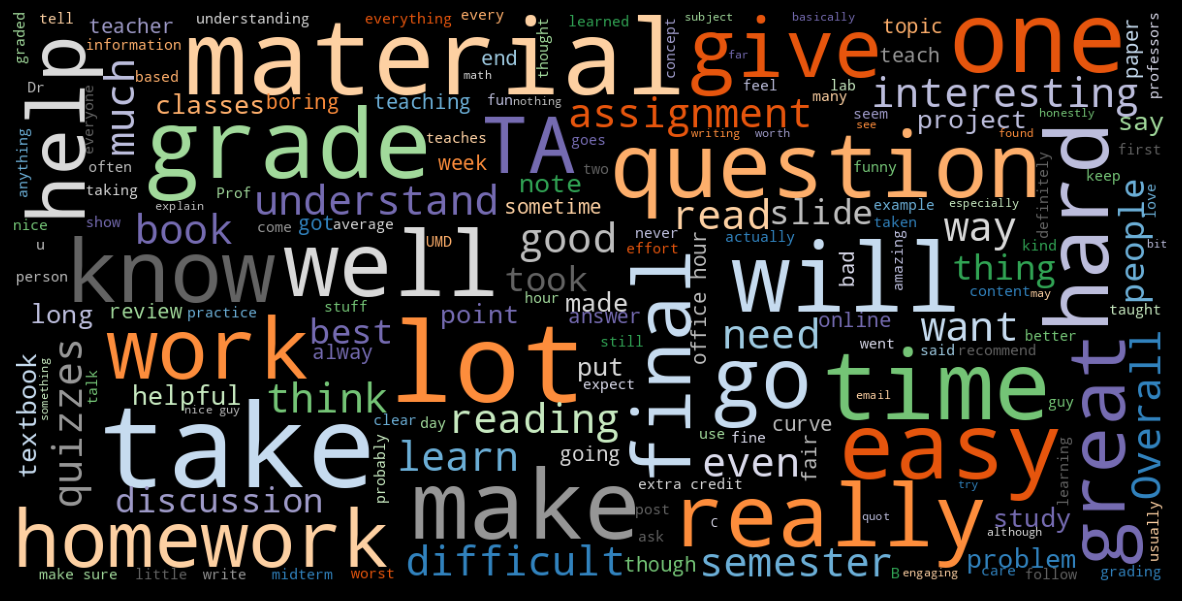

In [67]:
wc = WordCloud(
    background_color="black",
    max_font_size=40,
    scale=3,
    colormap='tab20c',
    stopwords=set(
        [
            "class",
            "course",
            "lecture",
            "professor",
            "student",
            "students",
            "exam",
            "exams",
            "test",
            "tests",
            "lectures",
        ]
    )
    | STOPWORDS,
).generate(merged_df["review"].str.cat(sep=" "))
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()


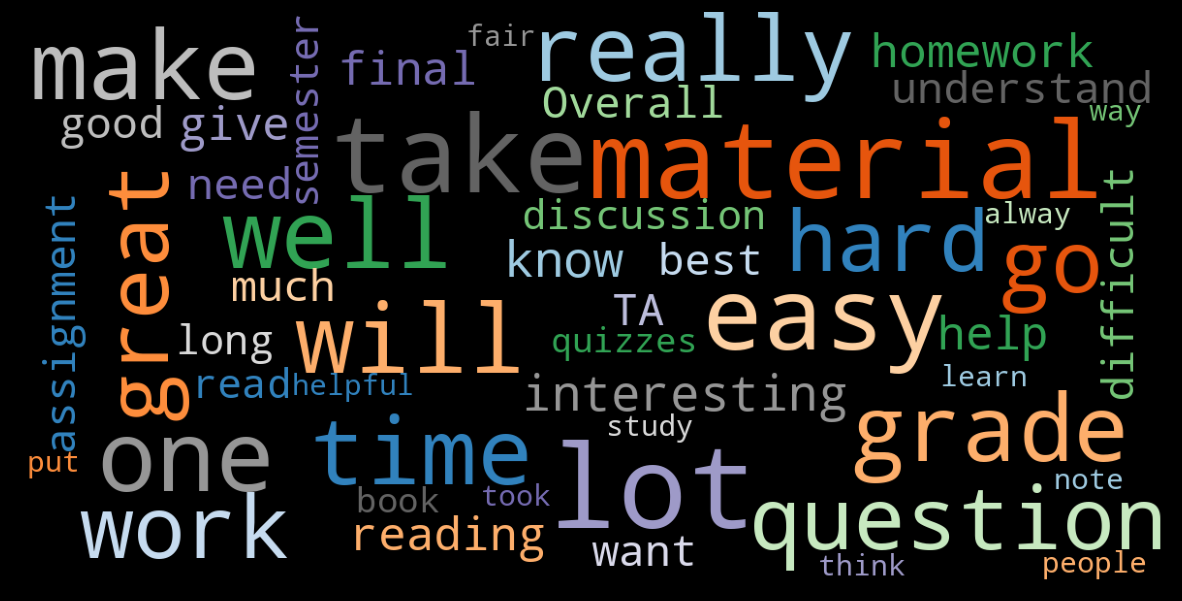

In [68]:
wc = WordCloud(
    background_color="black",
    max_font_size=40,
    max_words=50,
    scale=3,
    colormap='tab20c',
    stopwords=set(
        [
            "class",
            "course",
            "lecture",
            "professor",
            "student",
            "students",
            "exam",
            "exams",
            "test",
            "tests",
            "lectures",
        ]
    )
    | STOPWORDS,
).generate(merged_df[merged_df["rating"] >= 3]["review"].str.cat(sep=" "))
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()


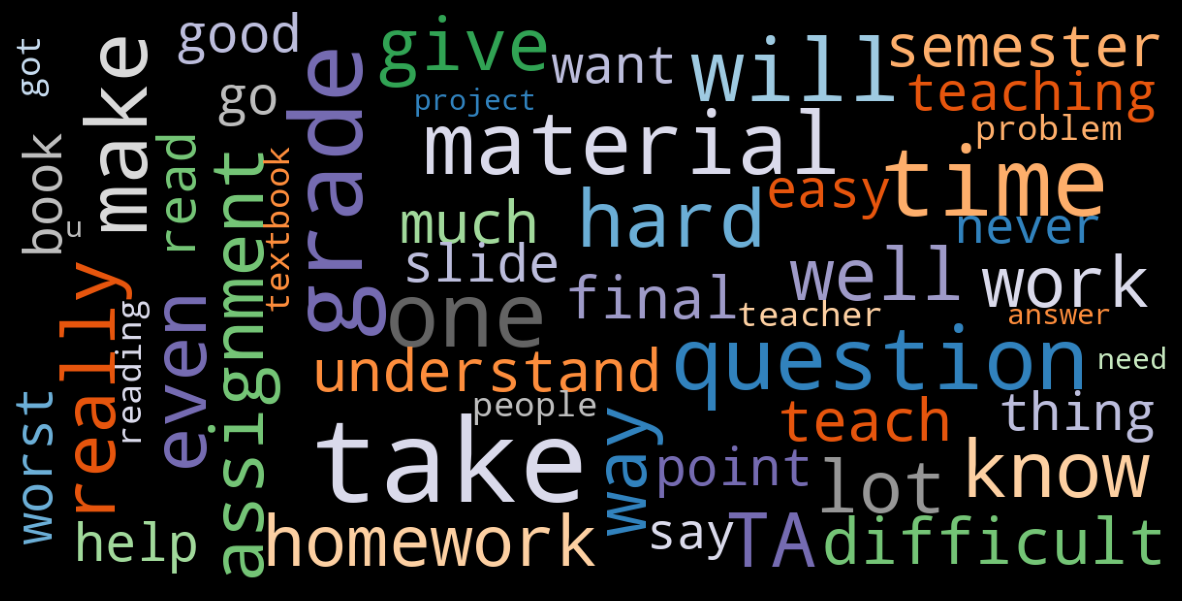

In [69]:
wc = WordCloud(
    background_color="black",
    max_font_size=40,
    max_words=50,
    scale=3,
    colormap='tab20c',
    stopwords=set(
        [
            "class",
            "course",
            "lecture",
            "professor",
            "student",
            "students",
            "exam",
            "exams",
            "test",
            "tests",
            "lectures",
        ]
    )
    | STOPWORDS,
).generate(merged_df[merged_df["rating"] < 3]["review"].str.cat(sep=" "))
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [70]:
merged_df.plot(
    kind="scatter",
    x="average_rating",
    y="salary",
    color="school",
    hover_data=['name'],
    trendline="ols"
)

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['name', 'year', 'school', 'salary', 'num_reviews', 'course', 'review', 'rating', 'created'] but received: average_rating

In [ ]:
sns.regplot(
    data=merged_df[merged_df["num_reviews"] > 10],
    x="average_rating",
    y="salary",
    line_kws={"color": "red"},
    fit_reg=True
)